# Feature engineering notebook

This is the final version of feature engineering notebook for solar model where we prepare our data for prediction. Prediction will be placed in a separate notebook. Going a little-bit upfront, we will be trying several regression models with our data set, including Random Forest algorithm and perhaps Neural Networks. Due to decision trees nature, the features will have to be engineered slightly differently:
> Example: 
> * Random forests do not benefit from too large feature spaces, since they select at random sqrt(p) or p/3 features, where p is total number of features. Therefore, when working with discretization and encoding of some of the numerical variables it is beneficial not to increase the feature space by one-hot encoding and using dummy variables. Instead, we will keep them in the same feature as a categorical variable.
> * For Neural Networks we would perform data scaling that is unneccessary for decision tree algorithms.

### Important notice: variable division transformations are done on the Train set

Checklist and a quick overview of feature engineering steps:

- [x] Missing values
- [x] Target variable outliers
- [x] Discretization
- [x] Gaussian transformation
- [x] Feature scaling

# Prepare the data  
Notes:    
- Work on copies of the data (keep the original dataset intact).  
- Write functions for all data transformations you apply, for five reasons:  
    - So you can easily prepare the data the next time you get a fresh dataset  
    - So you can apply these transformations in future projects  
    - To clean and prepare the test set  
    - To clean and prepare new data instances  
    - To make it easy to treat your preparation choices as hyperparameters  

1. Data cleaning:  
    - Fix or remove outliers (optional).  
    - Fill in missing values (e.g., with zero, mean, median...) or drop their rows (or columns).  
2. Feature selection (optional):  
    - Drop the attributes that provide no useful information for the task.  
3. Feature engineering, where appropriates:  
    - Discretize continuous features.  
    - Decompose features (e.g., categorical, date/time, etc.).  
    - Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).
    - Aggregate features into promising new features.  
4. Feature scaling: standardize or normalize features.  


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#loading initial dataframe
df = pd.read_csv('../datasets/initial_dataframe.csv', delimiter=',')
df['datetime_converted'] = pd.to_datetime(df['datetime_converted'], utc=True)
df = df.set_index(pd.DatetimeIndex(df['datetime_converted'],dayfirst=True))
df = df.drop(columns='datetime_converted')

We have selected that we will delete __snow depth__, __horizontal visibility__ from the data set because the API call does not contain these values.

In [3]:
df = df.drop(columns=['Snow depth (cm)','Horizontal visibility (m)'])

It is important to separate our data intro training and testing set before engineering our features. Some techniques learn parameters from data, which is why it is important to learn this parameters only from the train set to avoid over-fitting. 

Separating the data into train and test involves randomness. Setting the seed ensures reproducibility of the results. Let's split into a typical 80-20%.

In [4]:
#train_test_split
# remember to set the seed!
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['Value (kWh)'], test_size = 0.2, random_state=42)

In [5]:
dfs = {'X_train': X_train, 'X_test': X_test}

for dataframe in dfs:
    dfs[dataframe].to_csv('../datasets/initial_train_test/initial_'+str(dataframe)+'.csv')

In [6]:
X_train.shape, X_test.shape

((35669, 11), (8918, 11))

## Missing values

#### Numerical variables

All of our variables were numerical and every variable had some missing values. We will check how we deal with those one by one.

To engineer missing values in numerical variables, we will:

- __Air temperature__ and __Dew-point temperature__ missing values in period of 2017-2018 will be replaced from __Kaisaniemi__ data
- We will check target variable for missing values where it might be 0, for example at nights when there cannot be no produced power
- for other variables, where no more than 5 % of the data is missing, we will discard

In [7]:
vars_with_na = [var for var in X_train.columns if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O']
#missing values in %
X_train[vars_with_na].isnull().mean()*100

Cloud amount (1/8)                 0.182231
Pressure (msl) (hPa)               0.131767
Relative humidity (%)              0.131767
Precipitation intensity (mm/h)     0.361659
Air temperature (degC)            11.808573
Dew-point temperature (degC)       3.793210
Wind direction (deg)               0.599961
Gust speed (m/s)                   0.580336
Wind speed (m/s)                   0.599961
Value (kWh)                        1.536348
Global radiation (W/m2)            0.072892
dtype: float64

In [8]:
#dropping na in these variables in train and test
X_train = X_train.dropna(subset=['Cloud amount (1/8)', 'Pressure (msl) (hPa)', 'Relative humidity (%)',
                          'Precipitation intensity (mm/h)', 'Wind direction (deg)', 'Gust speed (m/s)', 
                          'Wind speed (m/s)', 'Global radiation (W/m2)','Value (kWh)'])
X_test = X_test.dropna(subset=['Cloud amount (1/8)', 'Pressure (msl) (hPa)', 'Relative humidity (%)',
                          'Precipitation intensity (mm/h)', 'Wind direction (deg)', 'Gust speed (m/s)', 
                          'Wind speed (m/s)', 'Global radiation (W/m2)','Value (kWh)'])

In [9]:
X_train.columns

Index(['Cloud amount (1/8)', 'Pressure (msl) (hPa)', 'Relative humidity (%)',
       'Precipitation intensity (mm/h)', 'Air temperature (degC)',
       'Dew-point temperature (degC)', 'Wind direction (deg)',
       'Gust speed (m/s)', 'Wind speed (m/s)', 'Value (kWh)',
       'Global radiation (W/m2)'],
      dtype='object')

#### Air temperature and Dew-point temperature

In [10]:
#let's upload kaisaniemi data
df_kaisaniemi1 = pd.read_csv('../datasets/kaisaniemi_17_18.csv')
df_kaisaniemi2 = pd.read_csv('../datasets/kaisaniemi_18_19.csv')
df_kaisaniemi = pd.concat([df_kaisaniemi1,df_kaisaniemi2],axis=0)

In [11]:
df_kaisaniemi['datetime'] = df_kaisaniemi['Year'].astype(str)+'-'+df_kaisaniemi['m'].astype(str)+'-'+df_kaisaniemi['d'].astype(str)+' '+ df_kaisaniemi['Time'].astype(str)
df_kaisaniemi['datetime_converted'] = pd.to_datetime(df_kaisaniemi['datetime'], utc=True)
df_kaisaniemi = df_kaisaniemi.set_index(pd.DatetimeIndex(df_kaisaniemi['datetime_converted'],dayfirst=True))
df_kaisaniemi = df_kaisaniemi.drop(columns=['Year','m','d','Time','Time zone','datetime','datetime_converted'])
df_kaisaniemi.columns = ['Air temperature (degC)','Dew-point temperature (degC)']
df_kaisaniemi = df_kaisaniemi.drop_duplicates()

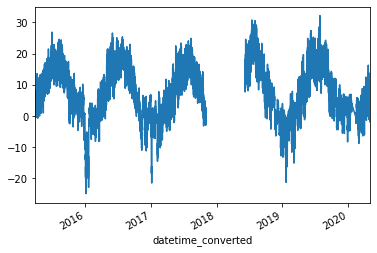

In [12]:
X_train['Air temperature (degC)'].plot()

In [13]:
#replacing NaN values in X_train and X_test for two columns with values that are not NaN and match on the index from df_kaisaniemi
X_train.update(df_kaisaniemi['Air temperature (degC)'], overwrite=False)
X_train.update(df_kaisaniemi['Dew-point temperature (degC)'], overwrite=False)
X_test.update(df_kaisaniemi['Air temperature (degC)'], overwrite=False)
X_test.update(df_kaisaniemi['Dew-point temperature (degC)'], overwrite=False)

C:\Users\screwdriver\Anaconda3\lib\site-packages\pandas\core\frame.py:5819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


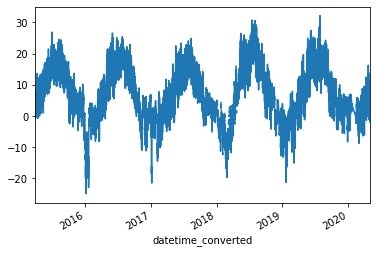

In [14]:
X_train['Air temperature (degC)'].plot()

Let's clear the rest of the rows with missing values and remove them completely

In [15]:
X_test.isnull().mean()*100

Cloud amount (1/8)                0.000000
Pressure (msl) (hPa)              0.000000
Relative humidity (%)             0.000000
Precipitation intensity (mm/h)    0.000000
Air temperature (degC)            2.997588
Dew-point temperature (degC)      0.815436
Wind direction (deg)              0.000000
Gust speed (m/s)                  0.000000
Wind speed (m/s)                  0.000000
Value (kWh)                       0.000000
Global radiation (W/m2)           0.000000
dtype: float64

In [16]:
X_train=X_train.dropna()
X_test=X_test.dropna()

In [17]:
X_test.isnull().mean()*100

Cloud amount (1/8)                0.0
Pressure (msl) (hPa)              0.0
Relative humidity (%)             0.0
Precipitation intensity (mm/h)    0.0
Air temperature (degC)            0.0
Dew-point temperature (degC)      0.0
Wind direction (deg)              0.0
Gust speed (m/s)                  0.0
Wind speed (m/s)                  0.0
Value (kWh)                       0.0
Global radiation (W/m2)           0.0
dtype: float64

Let's take care of the missing data in the target variable

## Numerical variable transformation

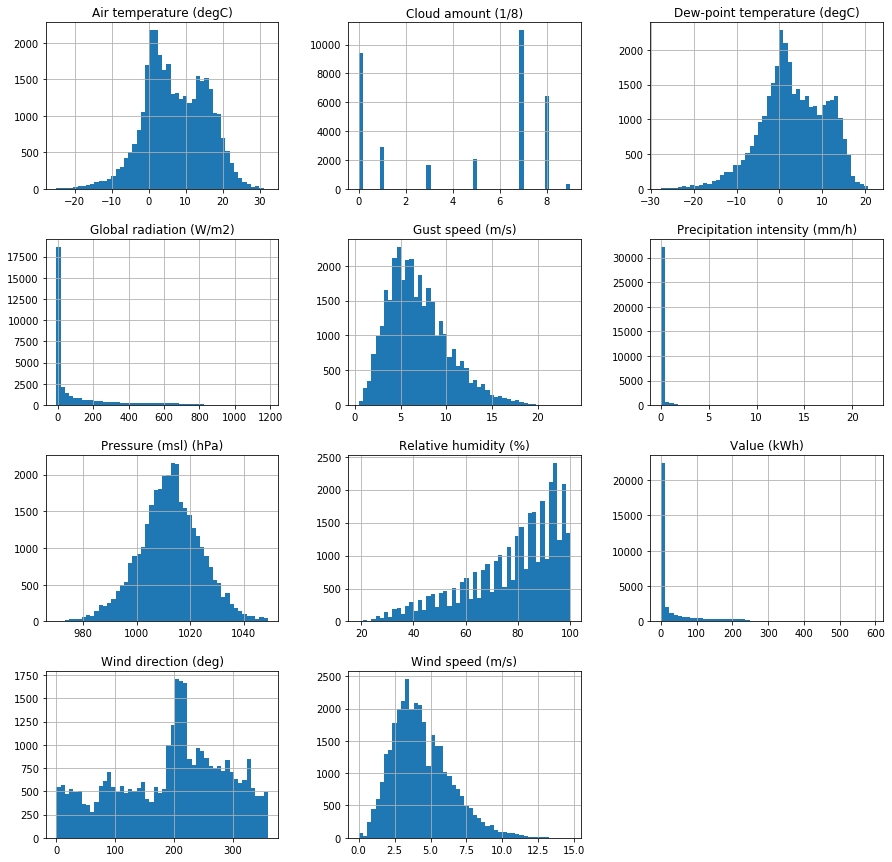

In [18]:
X_train.hist(bins=50,figsize=(15,15));

We will do the following things:
* Discretize Cloud amount, Wind direction and Precipitation intensity in the following section
* Pressure looks already quite Gaussian
* Try to transform the rest variables to improve the distribution in case we would like to test out the linear models

In [19]:
#without 'Pressure (msl) (hPa)'
vars_to_transform = ['Relative humidity (%)', 'Air temperature (degC)','Dew-point temperature (degC)','Gust speed (m/s)', 'Wind speed (m/s)', 'Global radiation (W/m2)']

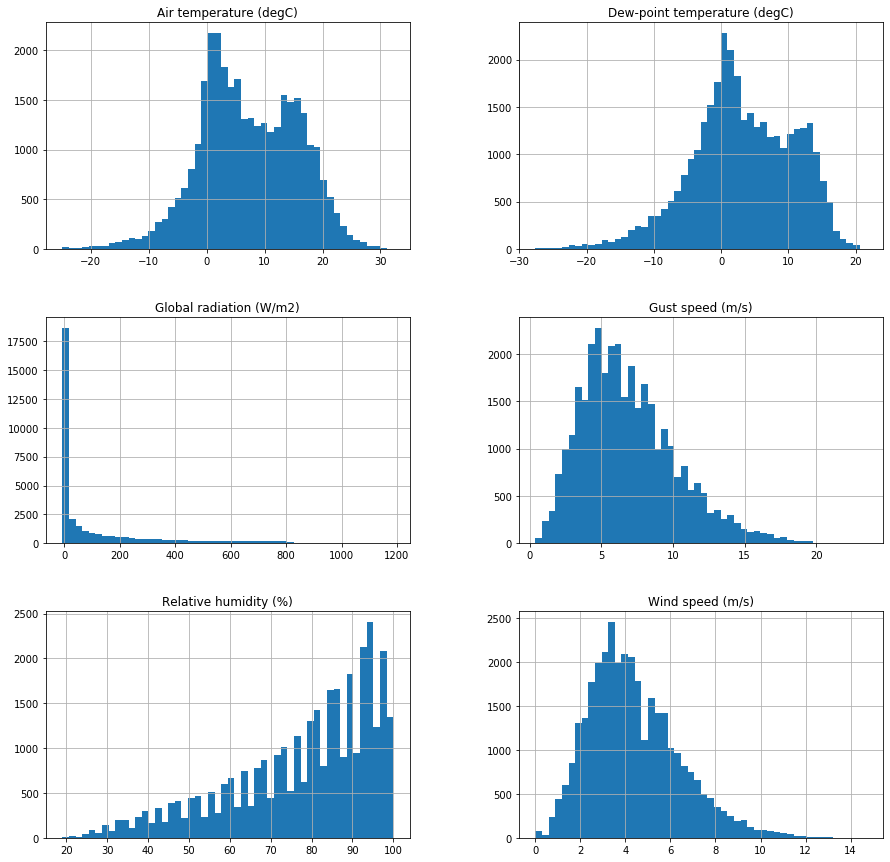

In [20]:
X_train[vars_to_transform].hist(bins=50, figsize=(15,15));

In [21]:
#let's try Yeo-Johnson transformation with Sklearn 
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
transformer = PowerTransformer(method='yeo-johnson', standardize=False)
transformer.fit(X_train[vars_to_transform])
data_t = transformer.transform(X_train[vars_to_transform])
data_t = pd.DataFrame(data_t, columns = vars_to_transform)

In [22]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # A function to plot a histogram and a Q-Q plot side by side for a variable
    plt.figure(figsize=(15,6))    
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(variable)
    plt.show()

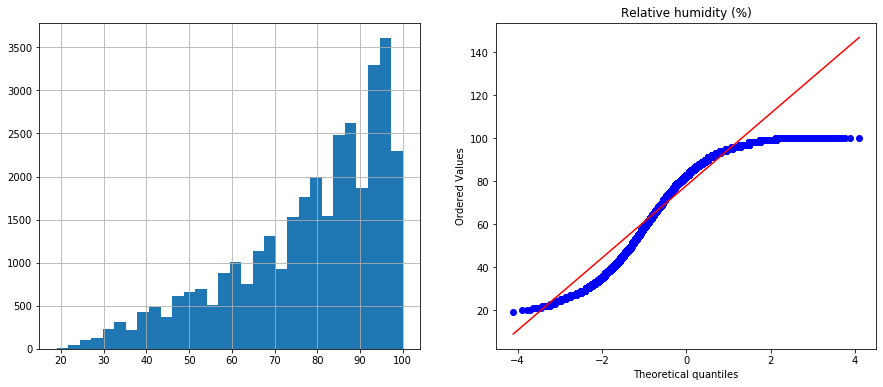

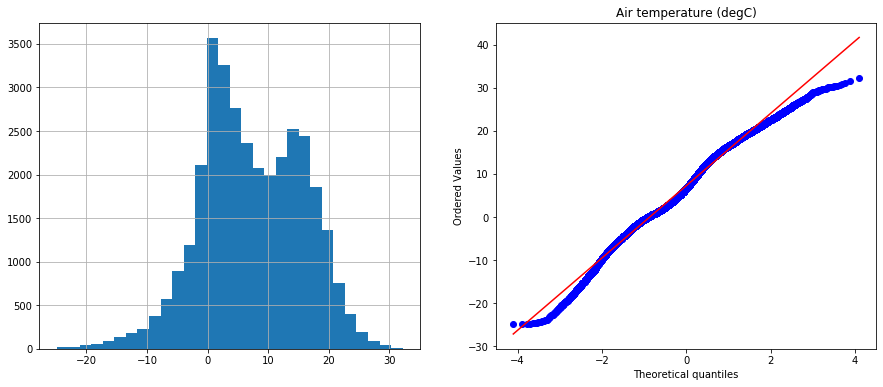

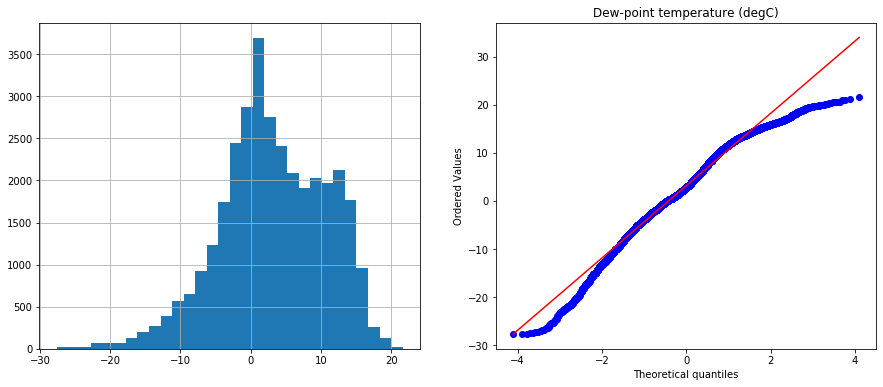

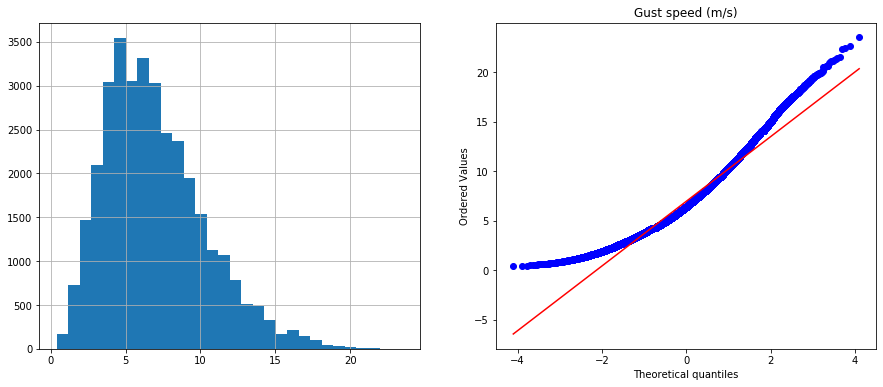

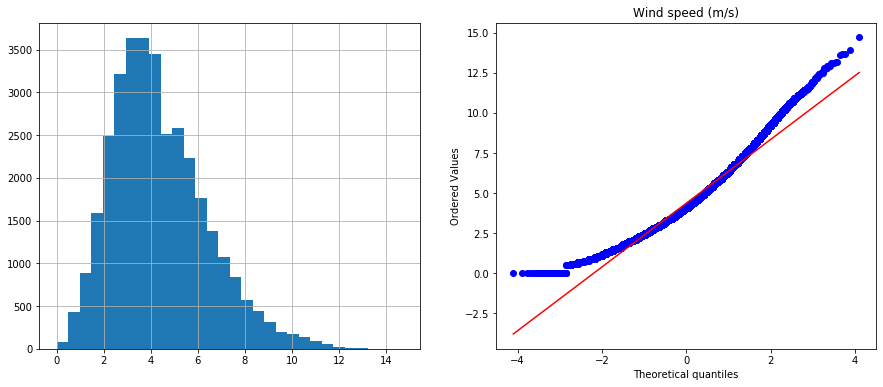

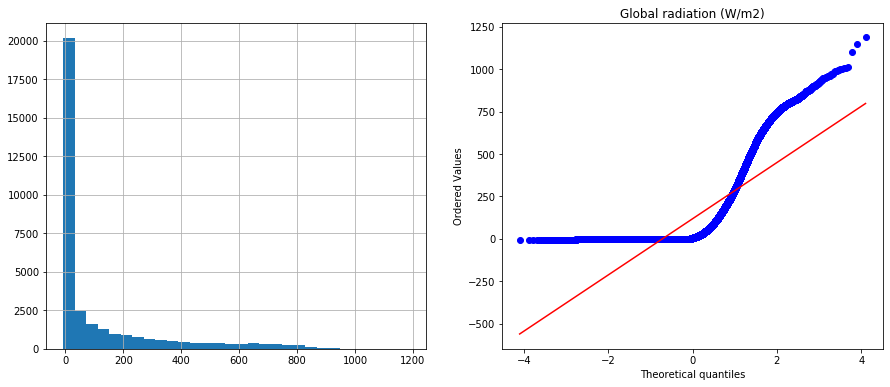

In [23]:
for var in vars_to_transform:
    diagnostic_plots(X_train, var)

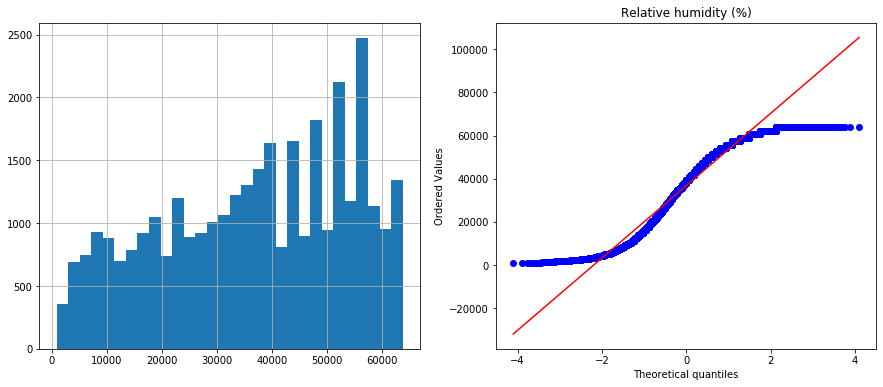

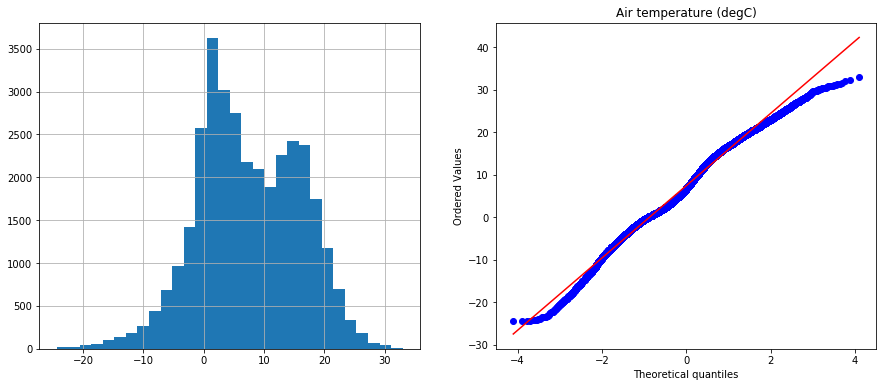

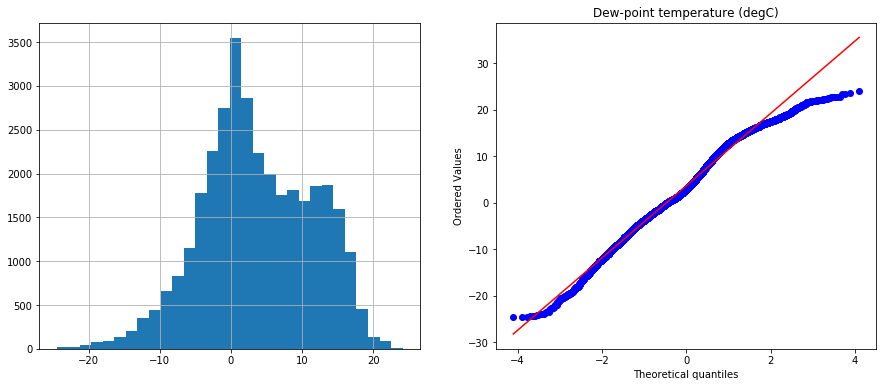

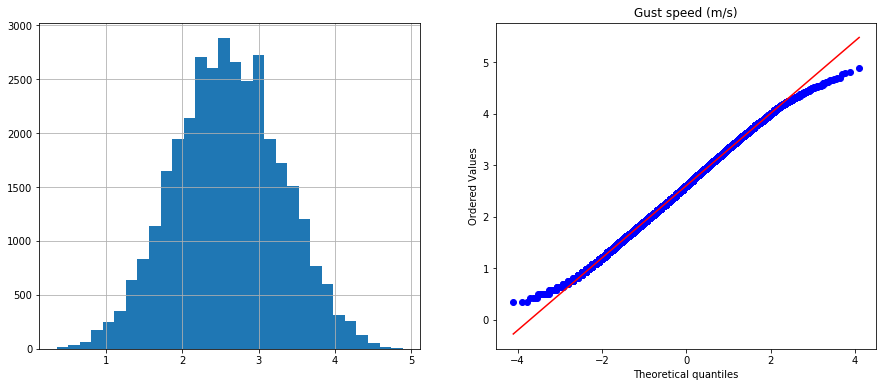

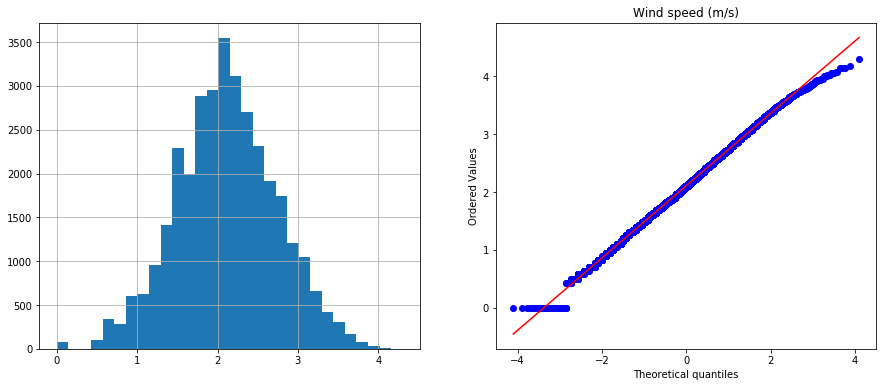

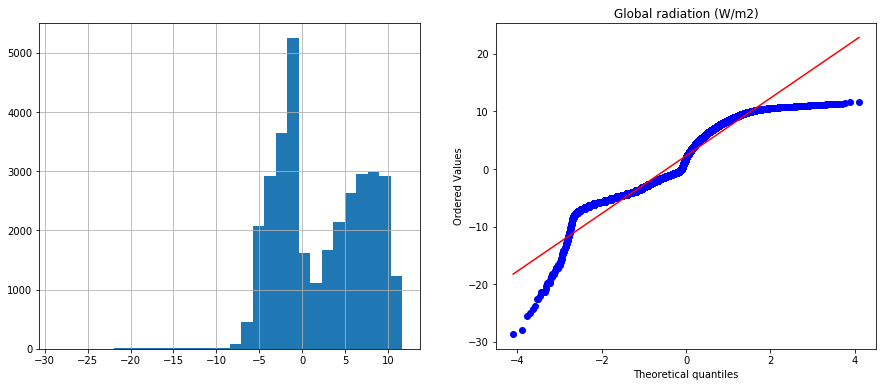

In [24]:
for var in vars_to_transform:
    diagnostic_plots(data_t, var)

In [25]:
transformer = FunctionTransformer(np.exp, validate=True)
data_t = transformer.transform(X_train[vars_to_transform])
data_t = pd.DataFrame(data_t, columns = vars_to_transform)

C:\Users\screwdriver\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:165: RuntimeWarning: overflow encountered in exp
  return func(X, **(kw_args if kw_args else {}))


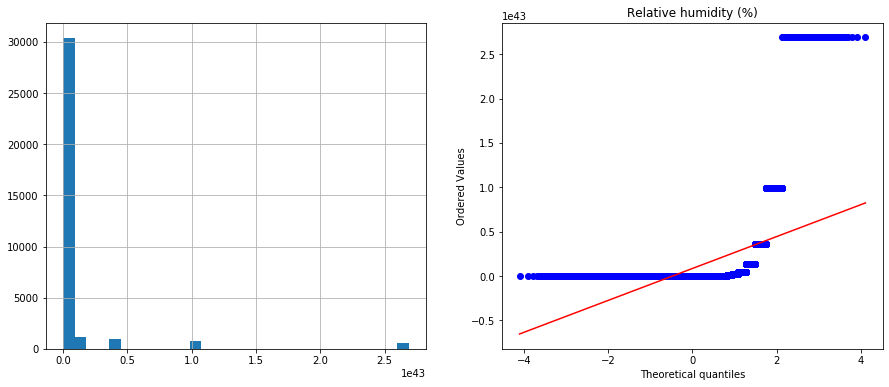

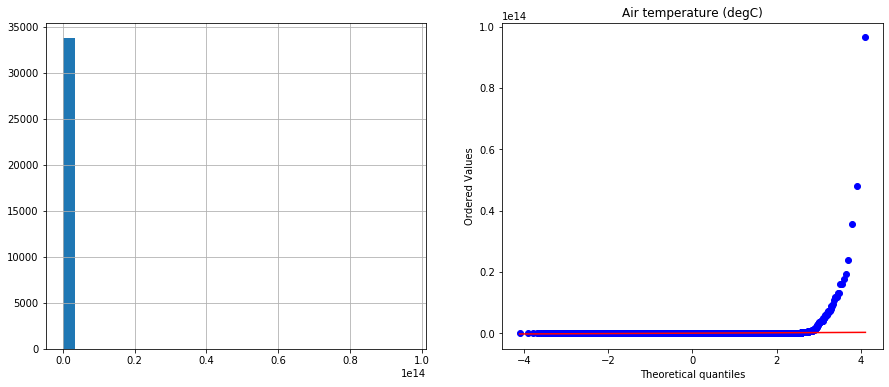

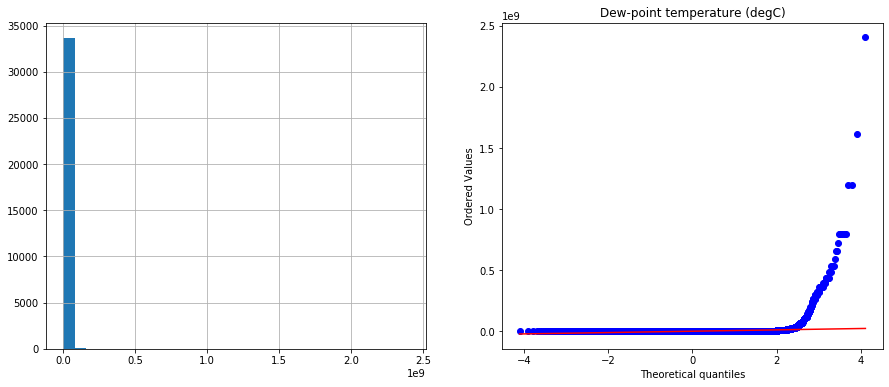

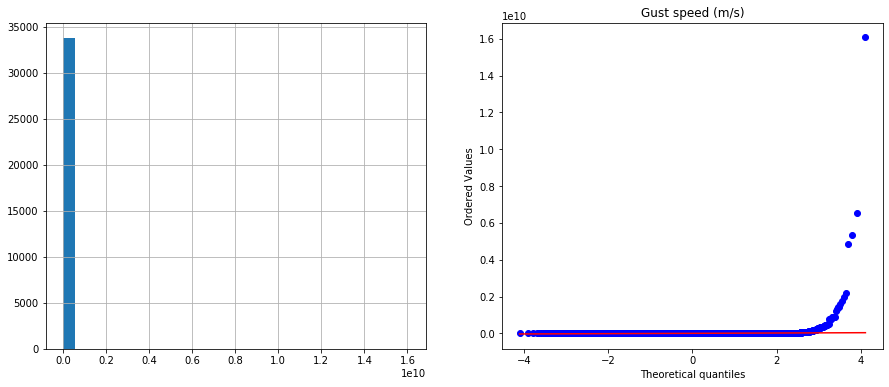

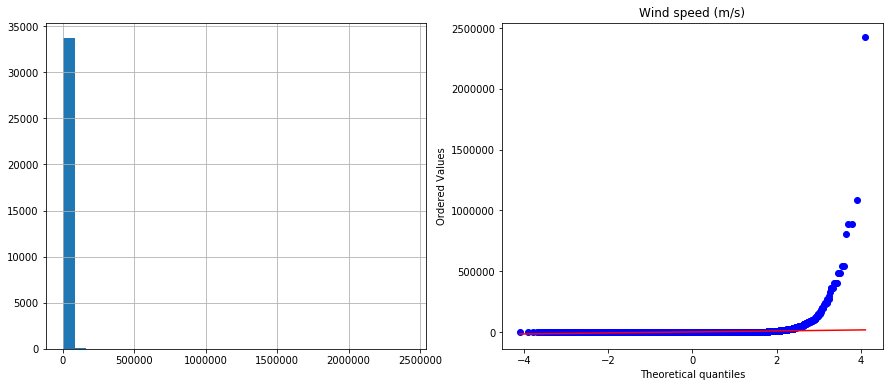

ValueError: supplied range of [0.0005530843701478336, inf] is not finite

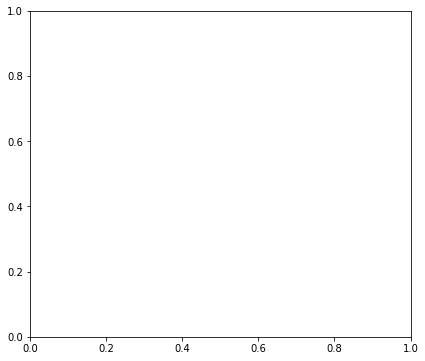

In [26]:
for var in vars_to_transform:
    diagnostic_plots(data_t, var)

* Yeo-Johnson method only helped for Wind speed and Gust speed
* Box-Cox and Logarithmic can only be applied to positive data
* Reciprocal (1/x) cannot be applied to data equal to 0
* Exponential would not improve things

This will not be a part of a pipeline

## Discretization

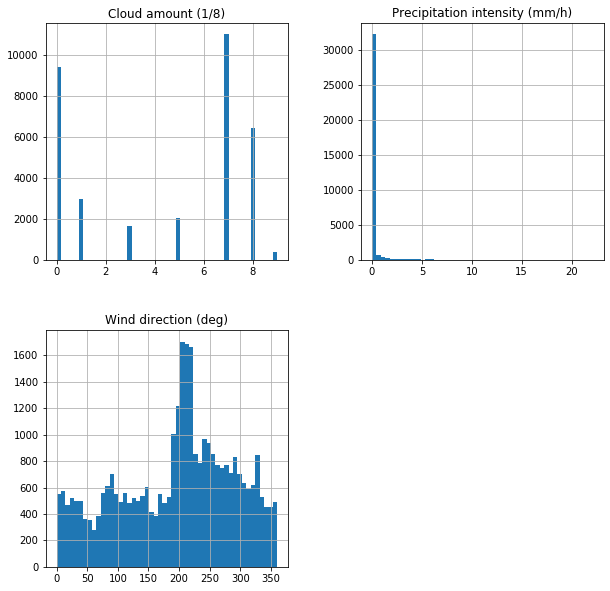

In [27]:
vars_to_discretize = ['Cloud amount (1/8)','Wind direction (deg)','Precipitation intensity (mm/h)']
X_train[vars_to_discretize].hist(bins=50, figsize=(10,10));

We will do the following:
* Wind direction will be replaced by a categorical variable, e.g. North, South-West, etc.
* We will try to reduce the number of bins for Cloud amount to get a more even distribution of values within the variable
* Since there is a dominant number of Precipitation equal to 0 mm/h, we will change this variable into a Binary variable, that would indicate no precipitation as 0, and precipitation as 1

### Wind direction

In [28]:
len(X_train['Wind direction (deg)'].unique())

361

In [29]:
360-11.25

348.75

We apply the following function add 360 degrees to those values, where the degree lies from 0 to 11.25, so that we can convert that together with the values on the other side of the circle (360-11.25) degrees. The sector is 348.75 until 11.25 degrees

In [30]:
X_train['Wind direction (deg)'][(X_train['Wind direction (deg)']>=0)&(X_train['Wind direction (deg)']<11.25)] = X_train['Wind direction (deg)'].apply(lambda x: x+360)
X_test['Wind direction (deg)'][(X_test['Wind direction (deg)']>=0)&(X_test['Wind direction (deg)']<11.25)] = X_test['Wind direction (deg)'].apply(lambda x: x+360)

In [31]:
# now we arrange the values into the following buckets with label names:
buckets = np.arange(11.25, 372, 22.5)
labels = np.array('N NNE NE ENE E ESE SE SSE S SSW SW WSW W WNW NW NNW N'.split())
X_train['Wind_direction'] = labels[np.digitize(X_train['Wind direction (deg)'], buckets)]
X_test['Wind_direction'] = labels[np.digitize(X_test['Wind direction (deg)'], buckets)]

In [32]:
X_train['Wind_direction'].unique()

array(['ESE', 'SSW', 'S', 'NE', 'NNW', 'W', 'WNW', 'WSW', 'SW', 'N', 'NW',
       'NNE', 'SSE', 'E', 'ENE', 'SE'], dtype=object)

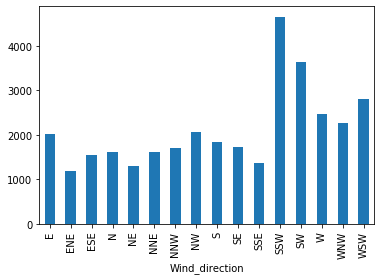

In [33]:
X_train.groupby('Wind_direction')['Wind direction (deg)'].count().plot.bar()

This looks like a better spread of winds than their degree values

Now we just need to convert them into numbers. We will not use one-hot encoding for this, instead, we will put a number for each of the groups in one column. This would benefit Random Forests better than expanding the feature set.

In [34]:
buckets = np.arange(11.25, 372, 22.5)
labels = np.array('N NNE NE ENE E ESE SE SSE S SSW SW WSW W WNW NW NNW N'.split())
labels = np.arange(17)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [35]:
buckets = np.arange(11.25, 372, 22.5)
labels = np.arange(17)
X_train['Wind_direction'] = labels[np.digitize(X_train['Wind direction (deg)'], buckets)]
X_test['Wind_direction'] = labels[np.digitize(X_test['Wind direction (deg)'], buckets)]

### Cloud amount
Making this binary

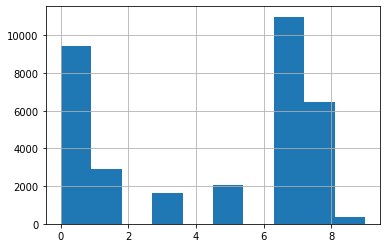

In [36]:
X_train['Cloud amount (1/8)'].hist()

In [37]:
print("Unique number of Cloud amounts ", len(X_train['Cloud amount (1/8)'].unique()))
print("Unique values ", X_train['Cloud amount (1/8)'].unique())

Unique number of Cloud amounts  7
Unique values  [8. 1. 0. 7. 5. 3. 9.]


In [38]:
len(X_train[X_train['Cloud amount (1/8)']<=5])

16025

In [39]:
len(X_train[X_train['Cloud amount (1/8)']>5])

17771

Maybe we can try to make it into a binary variable, where low amount of clowds (<=5) will be 0, and 1 otherwise

In [40]:
buckets = [0,5,10]
labels = ['<=5','>5']
X_train['Cloud_buckets_labels'] = pd.cut(X_train['Cloud amount (1/8)'], bins=buckets, labels=labels, include_lowest=True)
X_train['Cloud_buckets'] = pd.cut(X_train['Cloud amount (1/8)'], bins=buckets, include_lowest=True)

cols = ['Cloud amount (1/8)', 'Cloud_buckets_labels', 'Cloud_buckets']
X_train[cols].head()

,Cloud amount (1/8),Cloud_buckets_labels,Cloud_buckets
datetime_converted,,,
2018-12-08 09:00:00+00:00,8.0,>5,"(5.0, 10.0]"
2016-08-11 12:00:00+00:00,1.0,<=5,"(-0.001, 5.0]"
2019-11-29 09:00:00+00:00,8.0,>5,"(5.0, 10.0]"
2016-10-08 16:00:00+00:00,8.0,>5,"(5.0, 10.0]"
2019-07-27 23:00:00+00:00,0.0,<=5,"(-0.001, 5.0]"


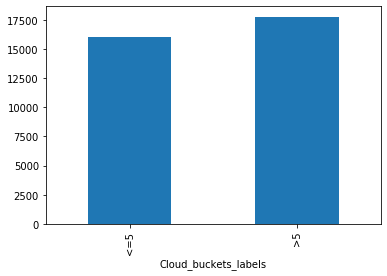

In [41]:
X_train.groupby('Cloud_buckets_labels')['Cloud amount (1/8)'].count().plot.bar()

A nicer division, than having rare bins with medium values of cloud amount

In [42]:
X_train['Cloud_amount_binary'] = np.where(X_train['Cloud amount (1/8)']>5,1,0)
X_test['Cloud_amount_binary'] = np.where(X_test['Cloud amount (1/8)']>5,1,0)

### Precipitation intensity
Making it binary

In [43]:
X_train['Precipitation intensity (mm/h)'].unique()

array([ 0. ,  0.8,  1.5,  0.5,  0.3,  0.4,  0.7,  0.2,  0.1,  3. ,  2.9,
        3.8,  1.2,  4.4,  1.6,  1.3,  1.9,  1.1,  2.5, 13.9,  5.9,  0.6,
        2.8,  2. ,  4. ,  1. ,  2.4,  1.7,  1.4,  2.6,  2.2,  2.3,  3.1,
        7.7,  7. ,  3.2,  0.9,  2.1,  7.4,  1.8,  4.6,  4.7,  4.1,  3.9,
        9.1, 21. ,  5.5,  5.6,  6.6,  2.7,  5.7,  8.2,  6.5,  5.8,  4.9,
        6.3, 13.3,  3.6,  3.4, 17.7, 20. ,  7.3,  8.8, 12.1,  3.5,  3.3,
        3.7,  7.1,  8.6,  4.3,  7.5,  9.5, 15.4,  6.1,  5. ,  7.8,  4.5,
        5.3,  6.9,  6.2,  8.9, 14.6, 22.1,  6.7,  8.5, 12.5,  5.2, 15.7])

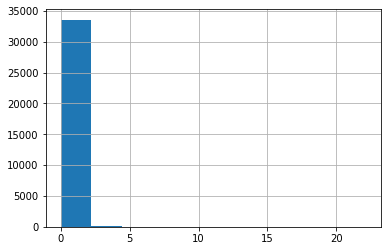

In [44]:
X_train['Precipitation intensity (mm/h)'].hist()

In [45]:
X_train['Precipitation_binary'] = np.where(X_train['Precipitation intensity (mm/h)'] > 0, 1,0)
X_test['Precipitation_binary'] = np.where(X_test['Precipitation intensity (mm/h)'] > 0, 1,0)

## Outliers

There were 2 clear outliers in our target variable that were visible with ordinary eye. Let's fix them first. \

Since we did not make any promising transformations of our numerical variables into a more Gaussian distribution, perhaps we can skip other outliers together with the linear models.

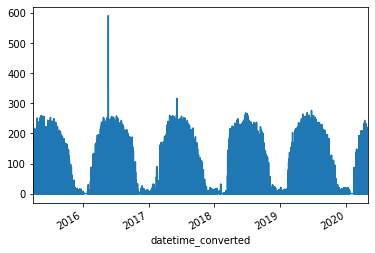

In [46]:
X_train['Value (kWh)'].plot()

In [47]:
X_train['Value (kWh)'][X_train['Value (kWh)']>300]

datetime_converted
2016-05-22 08:00:00+00:00    591.0
2017-06-07 15:00:00+00:00    316.0
Name: Value (kWh), dtype: float64

In [48]:
#let's try to find the values in the neighbouring hours around them and see if this is a realistic value
slice_1 = '2016-05-22 03:00:00+00:00'
slice_2 = '2016-05-22 12:00:00+00:00'

X_train['Value (kWh)'][(X_train['Value (kWh)'].index>=slice_1)&(X_train['Value (kWh)'].index<=slice_2)].sort_index()

datetime_converted
2016-05-22 03:00:00+00:00     21.0
2016-05-22 06:00:00+00:00    105.0
2016-05-22 07:00:00+00:00    137.0
2016-05-22 08:00:00+00:00    591.0
2016-05-22 09:00:00+00:00    226.0
2016-05-22 10:00:00+00:00    237.0
2016-05-22 11:00:00+00:00    240.0
2016-05-22 12:00:00+00:00    231.0
Name: Value (kWh), dtype: float64

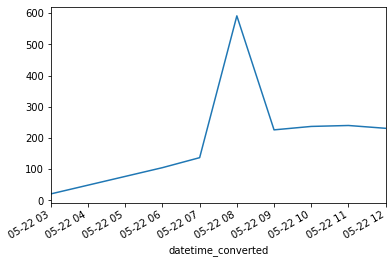

In [49]:
X_train['Value (kWh)'][(X_train['Value (kWh)'].index>=slice_1)&(X_train['Value (kWh)'].index<=slice_2)].sort_index().plot();

We will impute this value with the average of the neighbouring hours

In [50]:
slice_1 = '2016-05-22 07:00:00+00:00'
slice_2 = '2016-05-22 09:00:00+00:00'
(X_train['Value (kWh)'][X_train['Value (kWh)'].index==slice_1].values+X_train['Value (kWh)'][X_train['Value (kWh)'].index==slice_2].values)/2

array([181.5])

In [51]:
index_val = '2016-05-22 08:00:00+00:00'
X_train['Value (kWh)'].loc[index_val] = 181.5

C:\Users\screwdriver\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


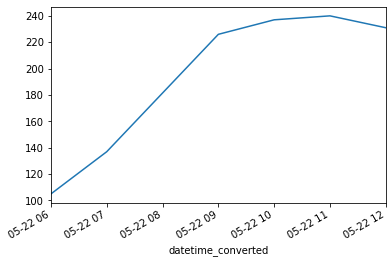

In [52]:
slice_1 = '2016-05-22 04:00:00+00:00'
slice_2 = '2016-05-22 12:00:00+00:00'
X_train['Value (kWh)'][(X_train['Value (kWh)'].index>=slice_1)&(X_train['Value (kWh)'].index<=slice_2)].plot();

Next value

datetime_converted
2017-06-07 14:00:00+00:00    173.0
2017-06-07 12:00:00+00:00    243.0
2017-06-07 16:00:00+00:00     55.0
2017-06-07 15:00:00+00:00    316.0
2017-06-07 17:00:00+00:00     34.0
2017-06-07 13:00:00+00:00    224.0
Name: Value (kWh), dtype: float64


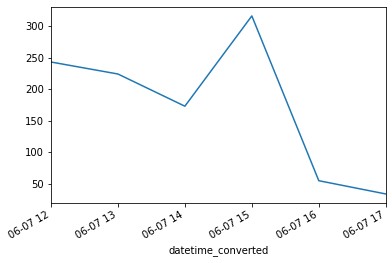

In [53]:
val_index = '2017-06-07 15:00:00+00:00'
slice_1 = '2017-06-07 12:00:00+00:00'
slice_2 = '2017-06-07 18:00:00+00:00'
print(X_train['Value (kWh)'][(X_train['Value (kWh)'].index>=slice_1)&(X_train['Value (kWh)'].index<=slice_2)])
X_train['Value (kWh)'][(X_train['Value (kWh)'].index>=slice_1)&(X_train['Value (kWh)'].index<=slice_2)].plot()
plt.show()

In [54]:
slice_1 = '2017-06-07 14:00:00+00:00'
slice_2 = '2017-06-07 16:00:00+00:00'
(X_train['Value (kWh)'].loc[slice_1].values+X_train['Value (kWh)'].loc[slice_2].values)/2

array([114.])

In [55]:
slice_1 = '2017-06-07 14:00:00+00:00'
slice_2 = '2017-06-07 16:00:00+00:00'
X_train['Value (kWh)'].loc[val_index] = 114

datetime_converted
2017-06-07 14:00:00+00:00    173.0
2017-06-07 12:00:00+00:00    243.0
2017-06-07 16:00:00+00:00     55.0
2017-06-07 15:00:00+00:00    114.0
2017-06-07 17:00:00+00:00     34.0
2017-06-07 13:00:00+00:00    224.0
Name: Value (kWh), dtype: float64


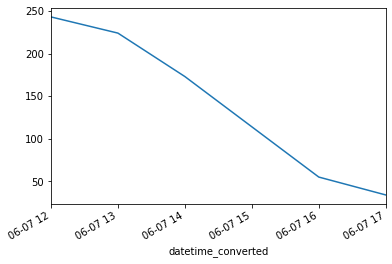

In [56]:
slice_1 = '2017-06-07 12:00:00+00:00'
slice_2 = '2017-06-07 18:00:00+00:00'
print(X_train['Value (kWh)'][(X_train['Value (kWh)'].index>=slice_1)&(X_train['Value (kWh)'].index<=slice_2)])
X_train['Value (kWh)'][(X_train['Value (kWh)'].index>=slice_1)&(X_train['Value (kWh)'].index<=slice_2)].plot()
plt.show()

I believe we can leave our outliers at this point, for we are not going to use linear models in this project. Both Random Forests and Neaural Networks were quite robust with dealing with outliers.

## Additional features
Additional features that we consider adding to our model are supposed to help the model understand the relationship between the inclination angle of solar panels on the power plant and the location of the sun in the sky. We also do not know the panel azimuth, thus, knowing sun azimuth might help.

List of additional variables:
* hour of the day
* day of the year 
* solar elevation angle (function of time of the day and day of the week)
* sun azimuth (function of time of the day and day of the week)

Maybe hour of the day and day of the week on their own are redundant

#### Hour of the day, day of the year

In [59]:
X_train['hour_of_day'] = X_train.index.hour
X_test['hour_of_day'] = X_test.index.hour

X_train['day_of_year'] = X_train.index.dayofyear
X_test['day_of_year'] = X_test.index.dayofyear

#### Solar elevation angle
Solar elevation angle is calculated from Latitude, Declination angle (between the Sun and the equator of the Earth, as well as solar time in hour angle (omega). More on this in http://sgemfinalreport.fi/files/WP611_photovoltaics%20HP%20Hellman.pdf
I have prepared a few functions for calculation and placed them in __azimuth_one_script.py__ in the root folder

In [63]:
from azimuth_one_script import *
longtitude = 24.9693
latitude = 60.1867
delta_GMT = 3


In [64]:
def calc_alpha_s_for_df(N, time, lon=longtitude, delta_GMT=3, phi=latitude):
    delta = calc_delta(N)
    omega = calc_omega(N, lon, delta_GMT, time)
    alpha_s = calc_alpha_s(phi, delta, omega)
    return alpha_s

def calc_sun_azimuth_for_df(N, time, lon=longtitude, delta_GMT=3, phi=latitude):
    delta = calc_delta(N)
    omega = calc_omega(N, lon, delta_GMT, time)
    alpha_s = calc_alpha_s(phi, delta, omega)
    gamma_s = calc_gamma_s(alpha_s, phi, delta, omega)
    return gamma_s

In [68]:
X_train['solar_elev_angle'] = X_train.apply(lambda x: calc_alpha_s_for_df(N=x['day_of_year'],time=x['hour_of_day']),axis=1)
X_test['solar_elev_angle'] = X_test.apply(lambda x: calc_alpha_s_for_df(N=x['day_of_year'],time=x['hour_of_day']),axis=1)

#### Solar azimuth

In [69]:
X_train['sun_azimuth'] = X_train.apply(lambda x: calc_sun_azimuth_for_df(N=x['day_of_year'],time=x['hour_of_day']),axis=1)
X_test['sun_azimuth'] = X_test.apply(lambda x: calc_sun_azimuth_for_df(N=x['day_of_year'],time=x['hour_of_day']),axis=1)

In [70]:
X_train.head()

,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),Value (kWh),Global radiation (W/m2),Wind_direction,Cloud_buckets_labels,Cloud_buckets,Cloud_amount_binary,Precipitation_binary,hour_of_day,day_of_year,solar_elev_angle,sun_azimuth
datetime_converted,,,,,,,,,,,,,,,,,,,,
2018-12-08 09:00:00+00:00,8.0,993.8,97.0,0.0,1.8,1.4,122.0,7.9,5.5,0.0,8.2,5,>5,"(5.0, 10.0]",1,0,9,342,-7.455357,-72.391329
2016-08-11 12:00:00+00:00,1.0,1008.5,64.0,0.0,16.5,9.7,197.0,11.5,7.3,198.0,448.6,9,<=5,"(-0.001, 5.0]",0,0,12,224,41.954084,-63.085877
2019-11-29 09:00:00+00:00,8.0,987.0,96.0,0.8,5.0,4.4,177.0,13.8,7.2,0.0,12.5,8,>5,"(5.0, 10.0]",1,1,9,333,-6.150531,-72.416977
2016-10-08 16:00:00+00:00,8.0,1029.0,57.0,0.0,8.5,0.5,36.0,13.6,8.2,0.0,-1.7,2,>5,"(5.0, 10.0]",1,0,16,282,14.392571,69.051716
2019-07-27 23:00:00+00:00,0.0,1015.5,70.0,0.0,21.3,15.6,336.0,4.0,3.1,0.0,-2.9,15,<=5,"(-0.001, 5.0]",0,0,23,208,-5.283255,115.698145


## Feature scaling
Although, Decision Tree based algorithms can handle data without scaling, Neural Networks require feaqture scaling because the regression coefficients are directly influenced by the scale of the variable. Variables with larger scale will dominate over those the ones with smaller magnitudes. Gradient descent converges faster when features are on similar scales, etc.

We will save both and see which gives better result in the NN implementation. Let's get rid of some columns with strings and object type values.

In [71]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [72]:
X_train.columns

Index(['Cloud amount (1/8)', 'Pressure (msl) (hPa)', 'Relative humidity (%)',
       'Precipitation intensity (mm/h)', 'Air temperature (degC)',
       'Dew-point temperature (degC)', 'Wind direction (deg)',
       'Gust speed (m/s)', 'Wind speed (m/s)', 'Value (kWh)',
       'Global radiation (W/m2)', 'Wind_direction', 'Cloud_buckets_labels',
       'Cloud_buckets', 'Cloud_amount_binary', 'Precipitation_binary',
       'hour_of_day', 'day_of_year', 'solar_elev_angle', 'sun_azimuth'],
      dtype='object')

### Sidenote:
In data analysis notebook we saw that __Wind speed__ and __Gust speed__ were highly correlated and it would be better to remove one of them (__Gust speed__).

Correlated predictor variables provide redundant information. Variables should be correlated with the target, but uncorrelated among themselves. [Citation: M. Hall 1999, Correlation-based Feature Selection for Machine Learning, PhD Thesis]

In [74]:
features = ['Pressure (msl) (hPa)', 'Relative humidity (%)', 'Air temperature (degC)','Dew-point temperature (degC)',
            'Wind speed (m/s)', 'Global radiation (W/m2)', 'Wind_direction',
            'Cloud_amount_binary', 'Precipitation_binary','Value (kWh)',
            'hour_of_day', 'day_of_year', 'solar_elev_angle', 'sun_azimuth']
X_train = X_train[features]
X_test = X_test[features]

In [75]:
len(features)

14

In [76]:
#let's save our X_train and X_test
X_train.to_csv('../datasets/scaled_train_test/X_train_unscaled.csv',index=False)
X_test.to_csv('../datasets/scaled_train_test/X_test_unscaled.csv',index=False)

__Standardtization__

One of the most popular method is standartisation, which centres the variables at 0 and sets the variance to 1. It will preserve the shape of the original distribution and center the mean at 0.

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [78]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
X_train_scaled_standard = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_standard = pd.DataFrame(X_test_scaled, columns=X_test.columns)

__MinMaxScaling__

MinMaxScaling will squish the values from [0,1]. Thus, also affecting the outliers

In [80]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_minmax = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_minmax = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Let's save our datasets before model building in a separate folder - __scaled_train_test__ in __datasets__.

In [81]:
X_train_scaled_minmax.to_csv('../datasets/scaled_train_test/X_train_minmax.csv',index=False)
X_test_scaled_minmax.to_csv('../datasets/scaled_train_test/X_test_minmax.csv',index=False)
X_train_scaled_standard.to_csv('../datasets/scaled_train_test/X_train_standard.csv',index=False)
X_test_scaled_standard.to_csv('../datasets/scaled_train_test/X_test_standard.csv',index=False)

# Done here!